## Creating the dataset for R-peak detection from apnea-ecg dataset

In [1]:
import os
import numpy as np
import torch
import wfdb
import neurokit2 as nk
from customLib.vis import *
from customLib.preprocess import *
from customLib.dataset import split_dataset
from customLib.load_physionet_ecgs import load_physionet_ecgs
from models.models import LSTM
from customLib.peak_detection import detect_nk, find_mean_avg_r_peak_indices
from customLib.config import apnea_ecg_path, apnea_sampling_rate

In [2]:
fileNames = [ x.split(".")[0] for x in os.listdir(apnea_ecg_path) if x.endswith(".qrs") ]

ecg_and_respiration_files = [ x.split(".")[0] for x in os.listdir(apnea_ecg_path) if x.endswith("er.qrs") ]

In the description of the dataset on Physionet.org we can find the information that recordings c05 and c06 come from the same original recording. The recording c05 begins 80 seconds later than c06. Therefore we drop the recording c05.

In [3]:
fileNames.remove("c05")

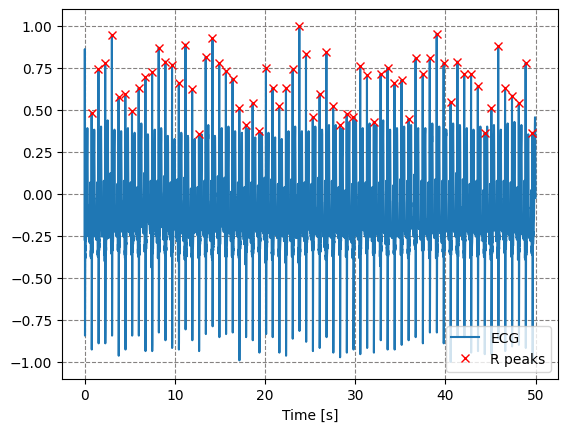

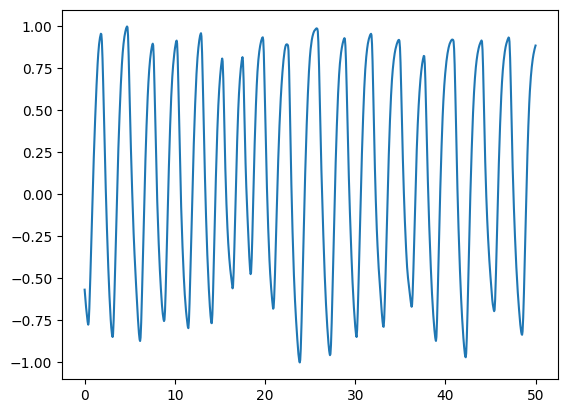

In [35]:
### Manually split an label ECGs with respiration

file = os.path.join(apnea_ecg_path, ecg_and_respiration_files[1])

window_num = 1
window_length = 5000

sampfrom=window_num * window_length
sampto=(window_num + 1) * window_length

record = wfdb.rdrecord(file, sampfrom=sampfrom, sampto=sampto)
annotation_ecg = wfdb.rdann(file, extension="qrs", sampfrom=sampfrom, sampto=sampto)

# final_annotations = np.unique(annotation_ecg.sample[np.in1d(annotation_ecg.symbol, ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r', 'F', 'e', 'j', 'n', 'E', 'f', 'Q', '?'])])
ECG = record.p_signal[:, 0]
ECG = norm_min_max(ECG, -1, 1)
RESP = record.p_signal[:, 3]
RESP = norm_min_max(RESP, -1, 1)

r_peaks = detect_nk(ECG, fs=100)

t = [x * 1/apnea_sampling_rate for x in range(len(ECG))]

annotation_apnea = wfdb.rdann(file, extension="apn", sampto=sampto)

plot_ecg(ECG, r_peaks=r_peaks, fs=100)
plt.plot(t, RESP)

### ECG denoising using wavelet transform
In the paper, authors ignore the D1, D2, D8 and D9 components of the wavelet decomposition (https://doi.org/10.1016/j.dsp.2005.12.003). The same action will be performed.

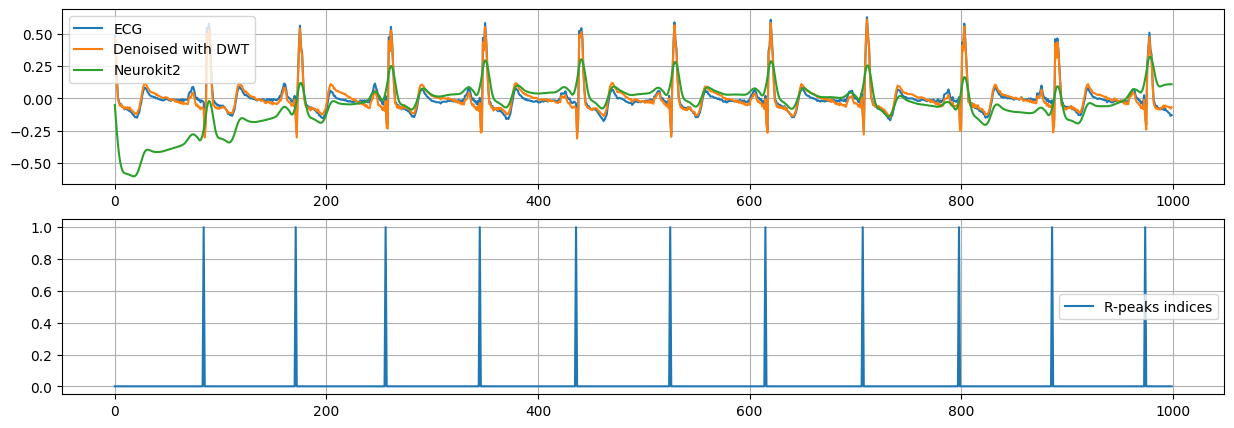

In [5]:
denoised_ecg = dwt_denoise(ECG)
r_peaks_signal = np.zeros_like(ECG)
r_peaks_signal[r_peaks] = 1

plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(ECG)
plt.plot(denoised_ecg)
plt.plot(nk.ecg_clean(ECG, sampling_rate=360))
plt.legend(["ECG", "Denoised with DWT", "Neurokit2"])
plt.grid()
plt.subplot(2,1,2)
plt.plot(r_peaks_signal)
plt.legend(["R-peaks indices"])
plt.grid()

## Loading the apnea-ecg data and splitting it into train, test and validate sets

In [ ]:
x , y = load_physionet_ecgs(path=apnea_ecg_path, annotation_file_extension="qrs", window_in_seconds=10, expand=False, denoise=True)
x_train, y_train, x_test, y_test, x_val, y_val = split_dataset(x, y, is_validation_set=True, shuffle=True, path=apnea_ecg_path+"\\dataset")

In [3]:
print("X_train shape: ", x_train.shape)
print("Y_train shape: ", y_train.shape)
print("X_test shape: ", x_test.shape)
print("Y_test shape: ", y_test.shape)
print("X_val shape: ", x_val.shape)
print("Y_val shape: ", y_val.shape)

X_train shape:  (162979, 1000)
Y_train shape:  (162979, 1000)
X_test shape:  (40745, 1000)
Y_test shape:  (40745, 1000)
X_val shape:  (20372, 1000)
Y_val shape:  (20372, 1000)


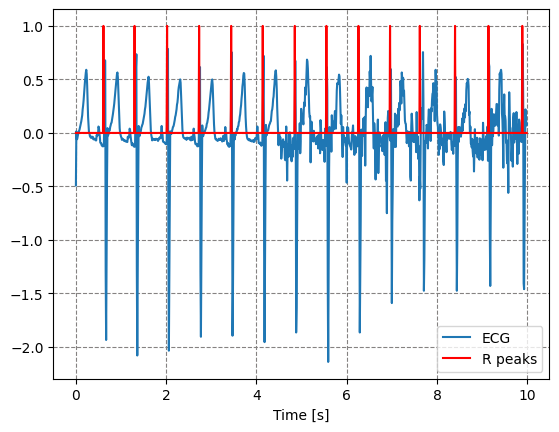

In [8]:
plot_ecg(x_train[0], y_train[0])